In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Introduction
Một tổ chức muốn dự đoán ai có thể vỡ nợ cho vay tiêu dùng. Họ có dữ liệu về hành vi lịch sử của khách hàng dựa trên những gì họ đã quan sát. Do đó, khi họ có được khách hàng mới, họ muốn dự đoán ai rủi ro hơn và ai không.

#### About Data
-	ID: Mã số duy nhất của người dùng.
-	Income: Thu nhập của người dùng.
-	Age: Tuổi của người dùng.
-	Experience: Kinh nghiệm chuyên môn của người dùng tính bằng năm.
-	Profession: Nghề nghiệp của người dùng.
-	Married/Single: Tình trạng hôn nhân của người dùng, có kết hôn hay chưa.
-	House_Ownership: Tình trạng sở hữu nhà, có sở hữu nhà, thuê nhà hay không sở hữu nhà.
-	Car_Ownership: Người dùng có sở hữu xe hơi hay không.
-	STATE: Bang hoặc vùng lãnh thổ cư trú của người dùng.
-	CITY: Thành phố hoặc khu vực cư trú của người dùng.
-	CURRENT_JOB_YRS: Số năm kinh nghiệm làm việc hiện tại của người dùng.
-	CURRENT_HOUSE_YRS: Số năm cư trú tại địa chỉ hiện tại của người dùng.
-	Risk_Flag: Biến mục tiêu, chỉ liệu người dùng đã gặp rủi ro về việc vỡ nợ hay không.

#### Importing necessary library and set options

In [2]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from scipy.stats import chi2_contingency
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
%matplotlib inline
sns.set_theme(color_codes=True, style='darkgrid',
              palette='deep', font='sans-serif')

## Importing Data and Data Cleansing

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/datasets/LoanPrediction_ML/Training Data.csv")
df.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


Exploring the data data type of each columns

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252000 entries, 0 to 251999
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Id                 252000 non-null  int64 
 1   Income             252000 non-null  int64 
 2   Age                252000 non-null  int64 
 3   Experience         252000 non-null  int64 
 4   Married/Single     252000 non-null  object
 5   House_Ownership    252000 non-null  object
 6   Car_Ownership      252000 non-null  object
 7   Profession         252000 non-null  object
 8   CITY               252000 non-null  object
 9   STATE              252000 non-null  object
 10  CURRENT_JOB_YRS    252000 non-null  int64 
 11  CURRENT_HOUSE_YRS  252000 non-null  int64 
 12  Risk_Flag          252000 non-null  int64 
dtypes: int64(7), object(6)
memory usage: 25.0+ MB


In [5]:
df.describe() # For numerical variables

,Id,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,252000.000000,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,126000.500000,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,72746.278255,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.000000,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,63000.750000,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,126000.500000,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,189000.250000,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,252000.000000,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


In [6]:
numerical_summary = df.describe() # For numerical variables
numerical_columns_count = numerical_summary.shape[1]
print(f'There are {numerical_columns_count} numeric columns in the dataset')

There are 7 numeric columns in the dataset


In [7]:
df.describe(include=['O']).T  # For categorical variables

,count,unique,top,freq
Married/Single,252000,2,single,226272
House_Ownership,252000,3,rented,231898
Car_Ownership,252000,2,no,176000
Profession,252000,51,Physician,5957
CITY,252000,317,Vijayanagaram,1259
STATE,252000,29,Uttar_Pradesh,28400


In [8]:
categorical_summary = df.describe(include=['O']).T
categorical_columns_count = categorical_summary.shape[0]
print(f'There are {categorical_columns_count} categorical columns in the dataset')

There are 6 categorical columns in the dataset


Checking for null values

In [9]:
df.isnull().sum()

Id                   0
Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64

There are no missing value in the datasets!

## Data Visualization

### Effect of House ownership on Risk Flag

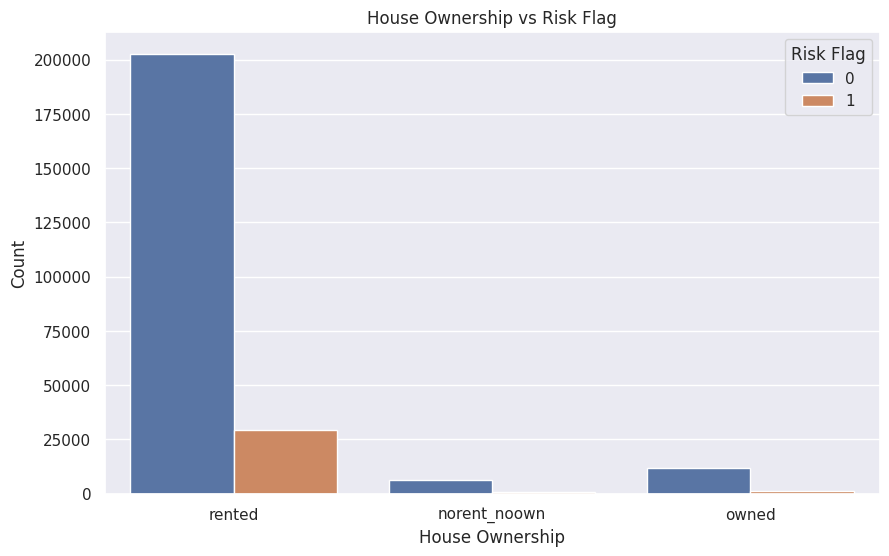

In [10]:
plt.figure(figsize=(10, 6))
sns.countplot(x='House_Ownership', hue='Risk_Flag', data=df)
plt.title('House Ownership vs Risk Flag')
plt.xlabel('House Ownership')
plt.ylabel('Count')
plt.legend(title='Risk Flag')
plt.show()

> Nhận xét

- Phân bố sở hữu nhà: Đa số người trong dữ liệu thuê nhà ('rented'), so với những người sở hữu nhà hoặc không có nhà.

- Rủi ro: Trong mỗi loại sở hữu nhà, số lượng người không có rủi ro (Risk Flag = 0) luôn nhiều hơn người có rủi ro (Risk Flag = 1).

- So sánh giữa các loại sở hữu: Cả ba nhóm đều cho thấy xu hướng tương tự về tỷ lệ giữa rủi ro và không rủi ro, tuy nhiên, nhóm thuê nhà có số lượng người có rủi ro tương đối cao so với tổng số người thuê nhà, điều này có thể liên quan đến đặc điểm tài chính hoặc điều kiện sống ảnh hưởng đến đánh giá rủi ro.

### Effect of Car owners on Risk Flag

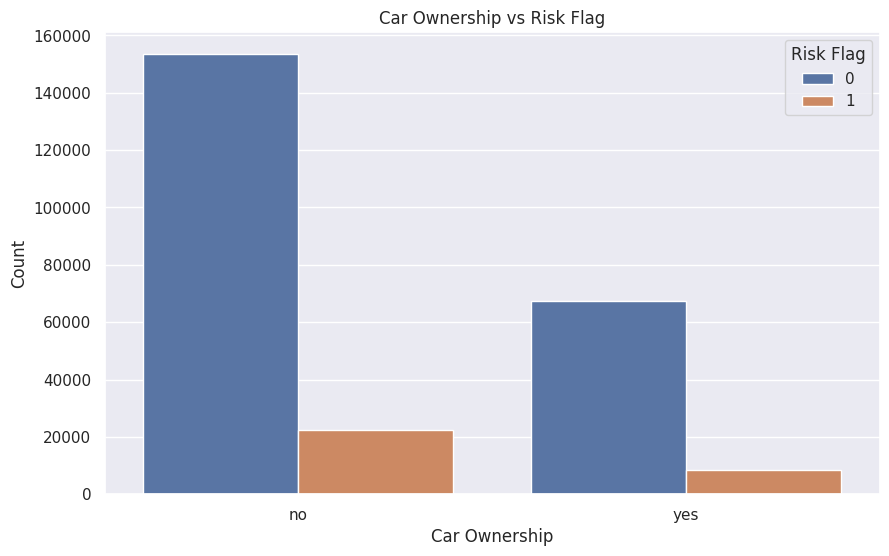

In [11]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Car_Ownership', hue='Risk_Flag', data=df)
plt.title('Car Ownership vs Risk Flag')
plt.xlabel('Car Ownership')
plt.ylabel('Count')
plt.legend(title='Risk Flag')
plt.show()

> Nhận xét

- Sự phân bố sở hữu xe hơi: Đa số người trong dữ liệu không sở hữu xe ('no'), so với những người sở hữu xe ('yes').

- Rủi ro: Trong cả hai nhóm sở hữu xe, số lượng người không có rủi ro (Risk Flag = 0) luôn nhiều hơn người có rủi ro (Risk Flag = 1), theo một tỷ lệ tương tự.

- So sánh giữa có và không có xe: Cả hai nhóm có tỷ lệ người có rủi ro so với tổng số người trong mỗi nhóm khá tương đương, điều này có thể cho thấy rằng sở hữu xe không có ảnh hưởng đáng kể đến việc đánh giá rủi ro cá nhân.

### Effect of Marital Status on Risk Flag

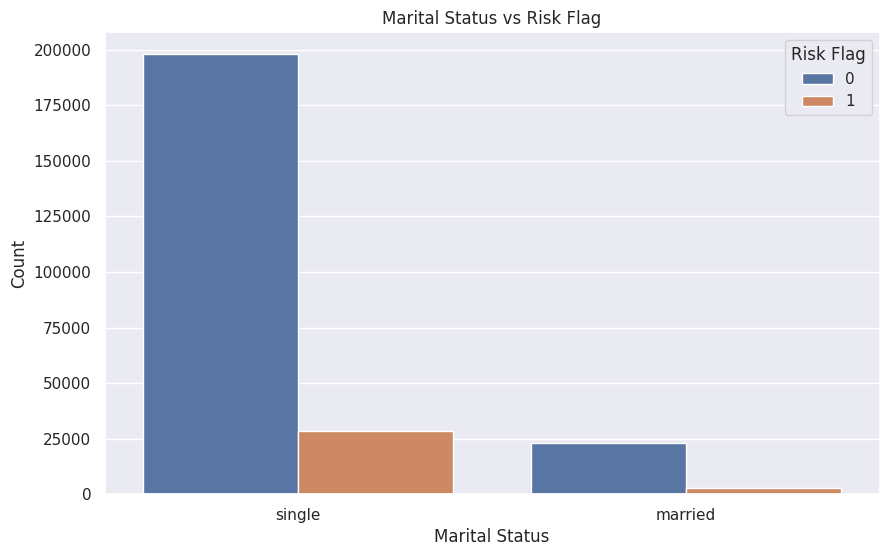

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(x='Married/Single', hue='Risk_Flag', data=df)
plt.title('Marital Status vs Risk Flag')
plt.xlabel('Marital Status')
plt.ylabel('Count')
plt.legend(title='Risk Flag')
plt.show()

> Nhận xét

- Phân bố tình trạng hôn nhân: Đa số người trong dữ liệu là độc thân ('single'), số lượng này nhiều hơn nhiều so với những người đã kết hôn ('married').

- Rủi ro: Trong cả hai nhóm tình trạng hôn nhân, số lượng người không có rủi ro (Risk Flag = 0) luôn nhiều hơn người có rủi ro (Risk Flag = 1).

- So sánh giữa độc thân và đã kết hôn: Nhóm độc thân có số lượng người có rủi ro tương đối cao so với tổng số người trong nhóm đó. Mặc dù nhóm đã kết hôn có tỷ lệ tương tự, nhưng số lượng tuyệt đối người có rủi ro thấp hơn nhiều do nhóm này ít người hơn.

### Effect of Profession on Risk Flag

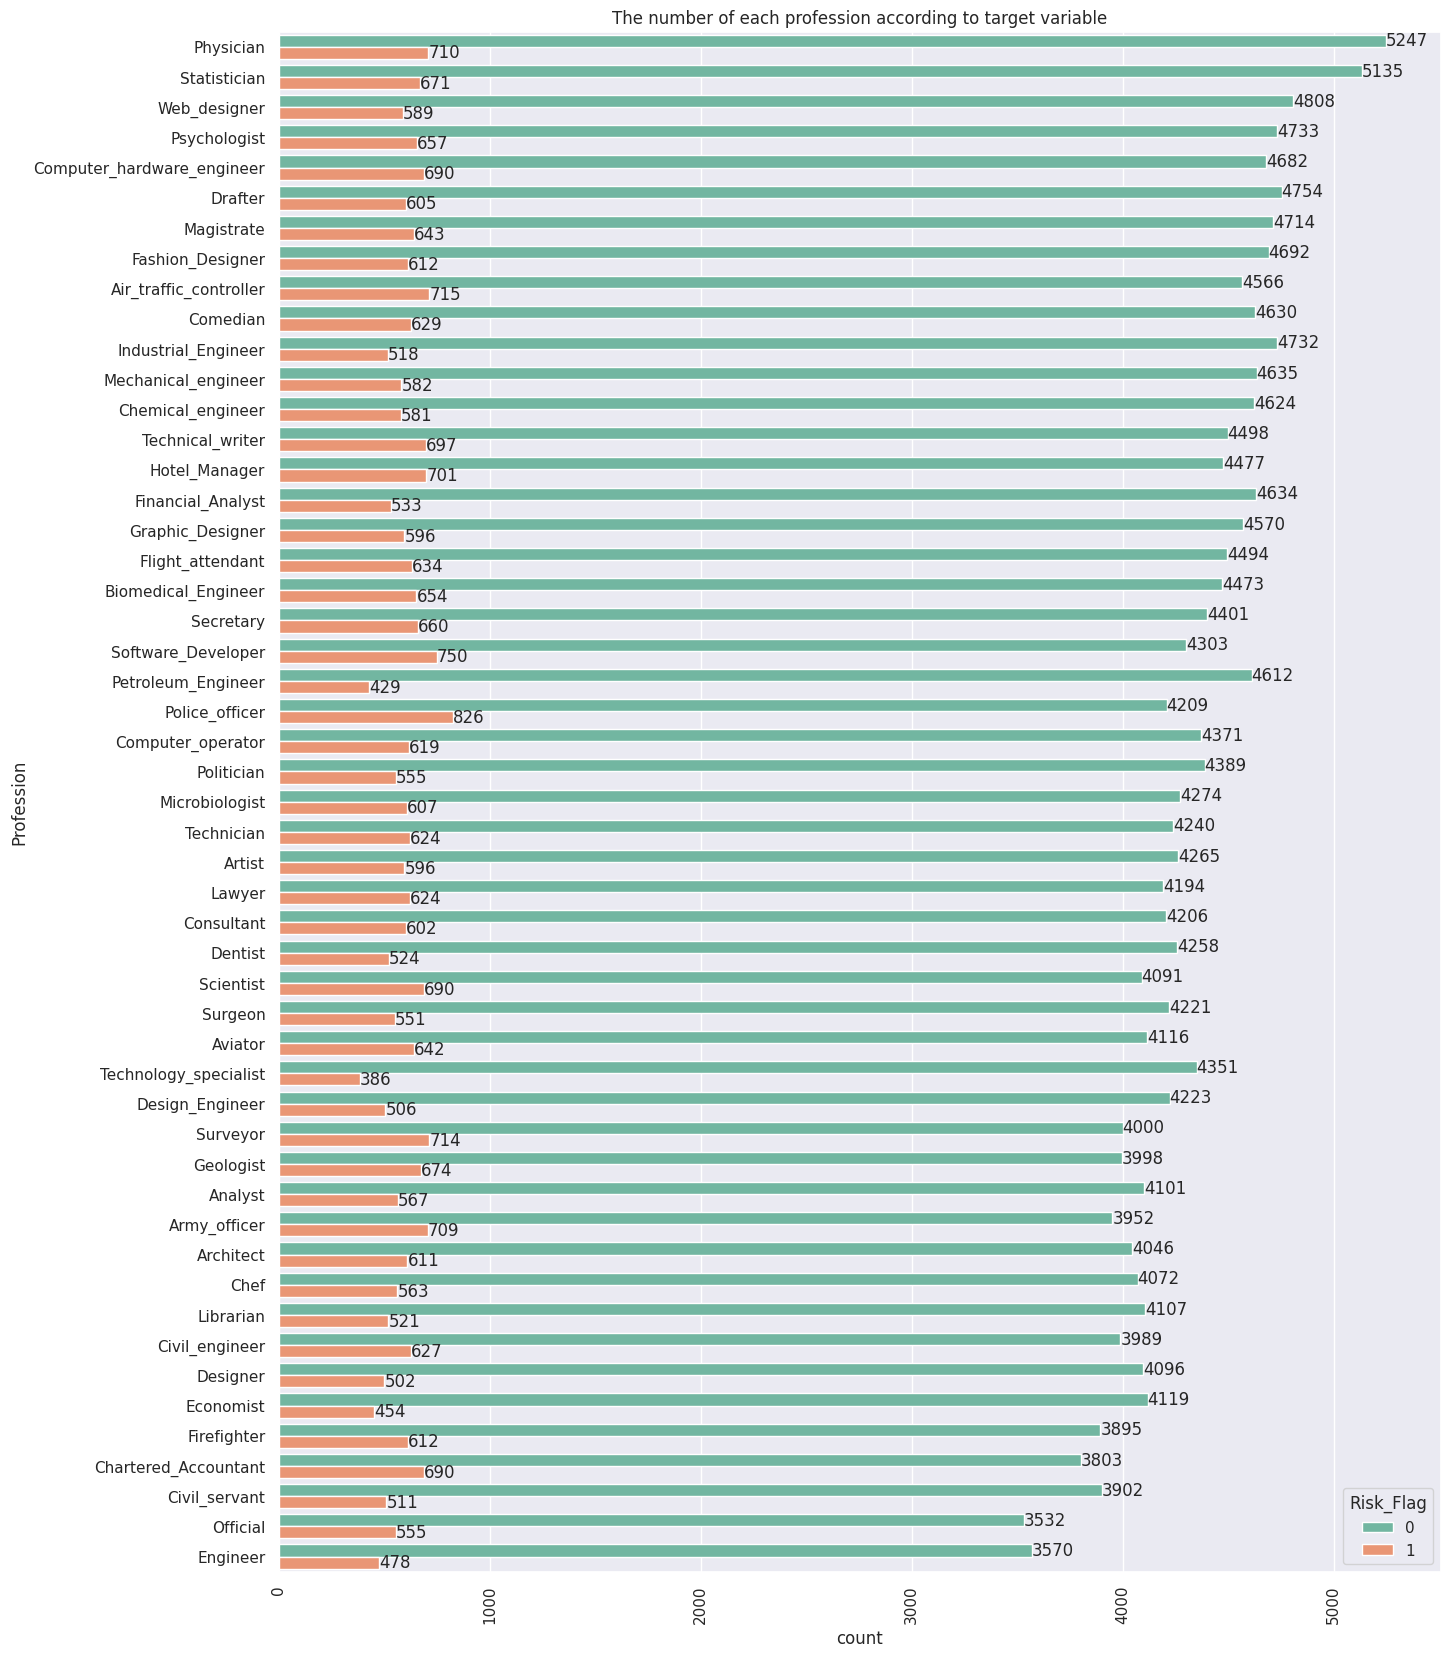

In [13]:
plt.figure(figsize=(15,20))
ax = sns.countplot(data = df , y=df["Profession"].sort_values(), hue  = "Risk_Flag",order = df['Profession'].value_counts().index, palette="Set2")
plt.xticks(rotation=90)
plt.title('The number of each profession according to target variable')
for bars in ax.containers:
        ax.bar_label(bars);

> Nhận xét

- Đa dạng nghề nghiệp: Biểu đồ thể hiện sự đa dạng của các nghề nghiệp trong tập dữ liệu. Các nghề như Physician, Software_Developer, và Mechanical_engineer có số lượng lớn, cả trong nhóm có rủi ro (Risk_Flag = 1) và không rủi ro (Risk_Flag = 0).

- Phân bố rủi ro: Trong hầu hết các nghề, số lượng cá nhân không có rủi ro (Risk_Flag = 0) luôn nhiều hơn so với những người có rủi ro. Điều này cho thấy, đa số cá nhân trong mỗi nghề được coi là ít rủi ro.

- Các nghề có rủi ro cao: Một số nghề như Civil_servant và Software_Developer có số lượng người có rủi ro đáng kể so với các nghề khác, điều này có thể phản ánh mức độ rủi ro tiềm ẩn cao hơn trong những nghề này.

Biểu đồ này hữu ích để nhận diện các nghề có tỷ lệ rủi ro cao hơn, từ đó có thể hỗ trợ trong việc đánh giá rủi ro và lập kế hoạch quản lý rủi ro dựa trên nghề nghiệp của cá nhân.

### Distribution ratio of City and State variables

In [14]:
df.groupby(['STATE', "CITY"]).Risk_Flag.apply(lambda x: x.sum()/x.size * 100).sort_values(ascending=False)

STATE           CITY            
Odisha          Bhubaneswar         32.619440
Madhya_Pradesh  Gwalior             27.272727
Bihar           Bettiah[33]         26.695842
Kerala          Kochi               25.286160
West_Bengal     Raiganj             23.955432
                                      ...    
Karnataka       Bangalore            3.713893
                Bijapur              3.496503
Delhi           Sultan_Pur_Majra     3.409091
Uttarakhand     Dehradun             2.634593
Gujarat         Gandhinagar          2.611367
Name: Risk_Flag, Length: 317, dtype: float64

> Nhận xét

- Bhubaneswar, Odisha: Thành phố này có tỷ lệ rủi ro cao nhất là khoảng 32.62%, điều này cho thấy một tỷ lệ đáng kể các trường hợp có rủi ro trong thành phố này.

- Gwalior, Madhya Pradesh: Tại đây, tỷ lệ rủi ro cũng rất cao, với 27.27%.

- Bettiah, Bihar: Thành phố này có tỷ lệ rủi ro là 26.70%.

- Kochi, Kerala: Một thành phố nổi tiếng khác với tỷ lệ rủi ro là 25.29%.

- Raiganj, West Bengal: Cũng có tỷ lệ rủi ro khá cao là 23.96%.

- Dehradun, Uttarakhand và Gandhinagar, Gujarat có tỷ lệ rủi ro thấp nhất, chỉ khoảng 2.63% và 2.61% tương ứng, cho thấy mức độ an toàn tài chính tốt trong những khu vực này.

Thông tin này có thể giúp đánh giá rủi ro tín dụng dựa trên địa lý và hỗ trợ trong việc phát triển các chiến lược can thiệp hoặc chính sách dựa trên từng khu vực cụ thể.

### Effect of STATE on Risk Flag

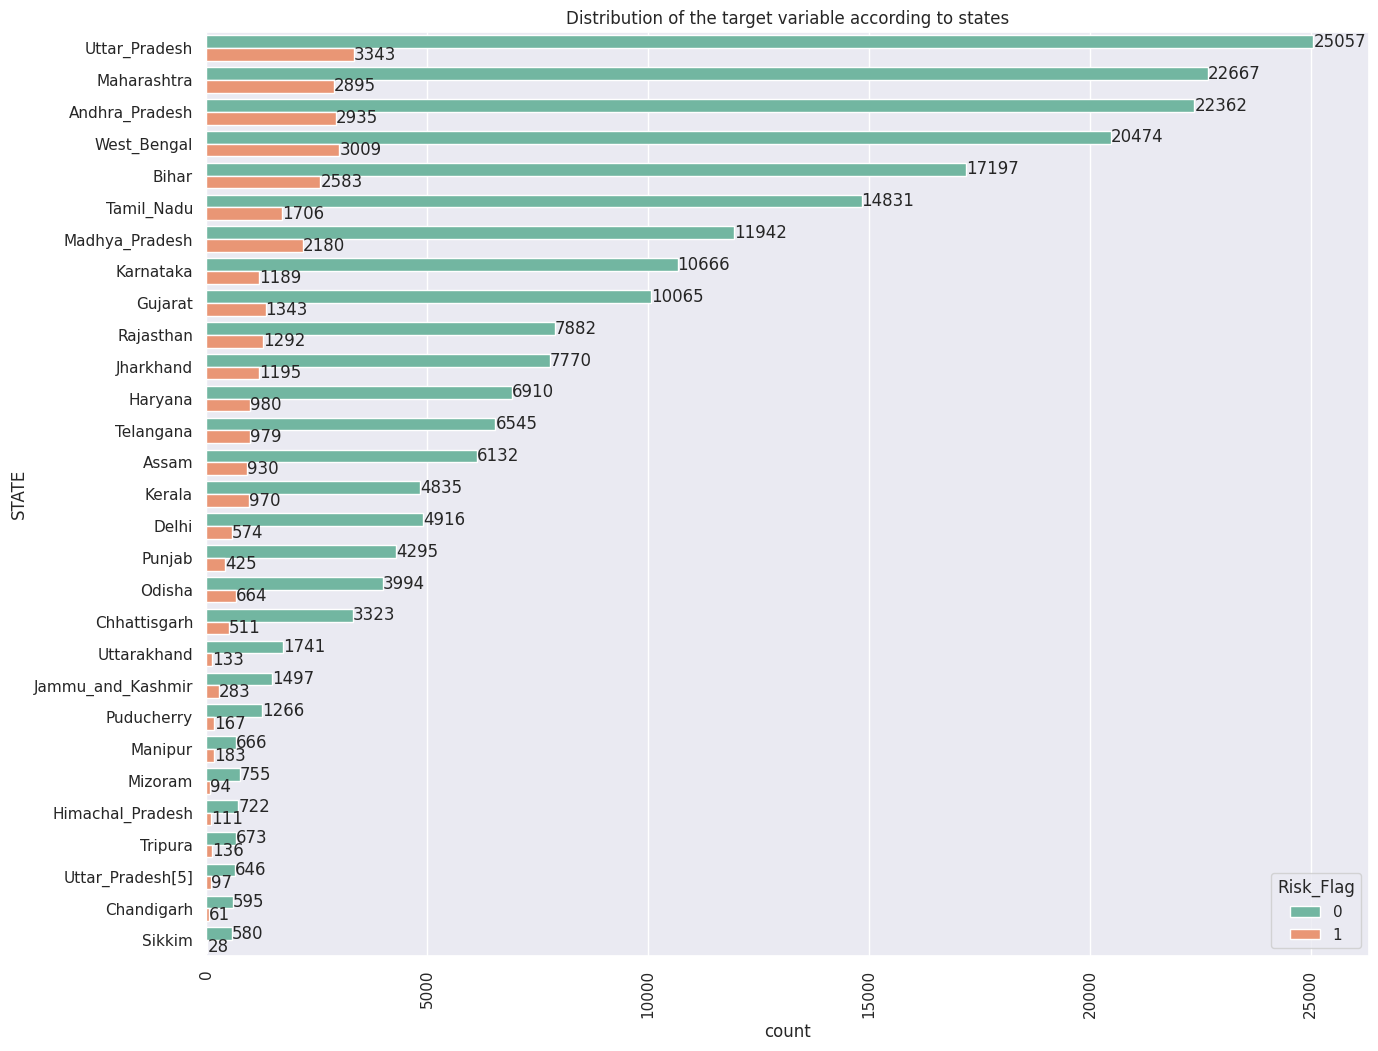

In [15]:
plt.figure(figsize=(15,12))
ax = sns.countplot(data = df , y=df["STATE"].sort_values(), hue= "Risk_Flag", order=df['STATE'].value_counts().index, palette="Set2")
plt.xticks(rotation=90)
plt.title('Distribution of the target variable according to states')
for bars in ax.containers:
        ax.bar_label(bars);

> Nhận xét

- Sự phân bố tổng quát: Các bang với số lượng mẫu lớn như Uttar Pradesh, Maharashtra, và Andhra Pradesh có số lượng cao cả trong nhóm không rủi ro (Risk_Flag = 0) và có rủi ro (Risk_Flag = 1).

- Sự chênh lệch giữa các bang: Một số bang có tỷ lệ người có rủi ro so với tổng số người cao hơn so với các bang khác. Ví dụ, bang Uttar Pradesh có một lượng lớn các trường hợp có rủi ro, điều này có thể liên quan đến các yếu tố kinh tế - xã hội cụ thể của bang.

- Bang ít rủi ro: Các bang như Kerala và Gujarat dường như có tỷ lệ rủi ro thấp hơn so với tổng số mẫu, điều này cho thấy sự ổn định tài chính hoặc hiệu quả trong việc quản lý rủi ro tại đây.

- Ghi nhận và nhãn: Mỗi cột trong biểu đồ được ghi nhãn rõ ràng với số lượng mỗi nhóm, giúp việc phân tích và so sánh giữa các bang trở nên dễ dàng hơn.

Biểu đồ này cung cấp cái nhìn tổng quan về mức độ phân bố rủi ro tín dụng tại các bang khác nhau, có thể hỗ trợ các nhà hoạch định chính sách hoặc các nhà quản lý rủi ro trong việc đưa ra các quyết định dựa trên bối cảnh địa lý. ​

### Distribution of Age

Dựa trên bảng mô tả dữ liệu dạng số ở trên, ta thấy các thông số của độ tuổi là có các giá trị tính toán cao nhất

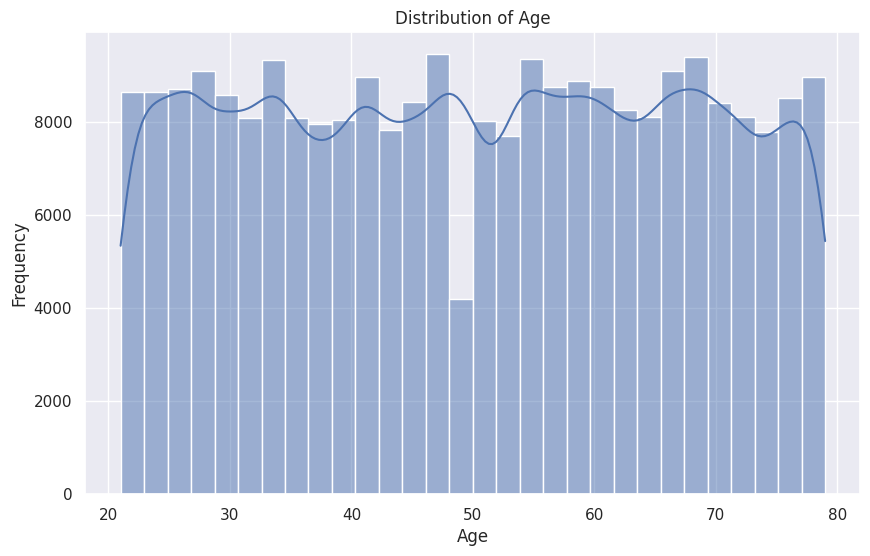

In [16]:
# Plotting the histogram for the "Age" column
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], kde=True, bins=30)
plt.title('Distribution of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

> Biểu đồ phân bố tuổi cho thấy một hình dạng khá đều và không có đỉnh rõ ràng, chỉ ra rằng dữ liệu tuổi trong tập dữ liệu được phân bố khá đồng đều qua các nhóm tuổi khác nhau. Có một số biến động nhỏ trong tần suất nhưng không có bất kỳ sự tập trung đáng kể nào vào một nhóm tuổi cụ thể. Điều này có thể cho thấy rằng dữ liệu bao gồm một dân số có độ tuổi khá đa dạng, không thiên về bất kỳ độ tuổi nhất định nào.

### Distribution of Income

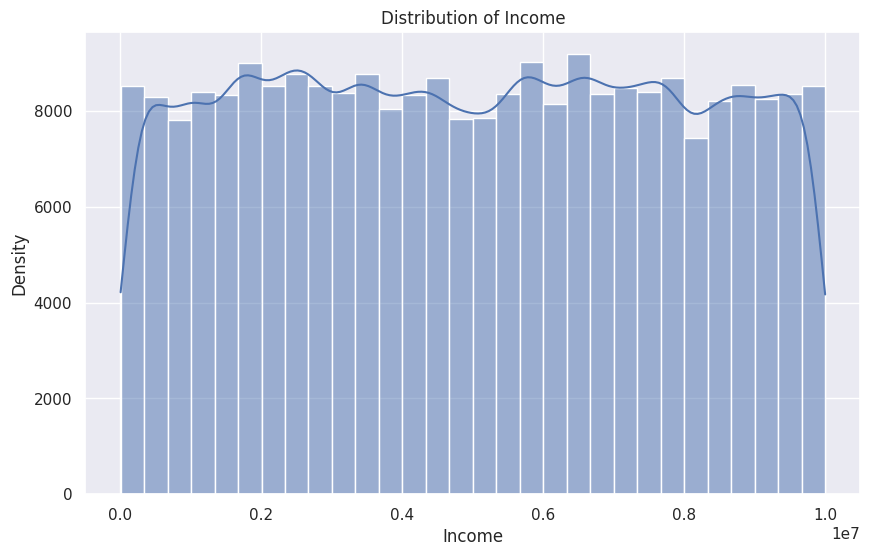

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Income'], kde=True, bins=30)
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Density')
plt.show()

> Nhận xét

- Phân bố thu nhập: Thu nhập có phân bố khá đều trên một phạm vi rộng, với một số biến động nhẹ ở các khoảng thu nhập khác nhau.

- Hình dạng của phân bố: Phân bố thu nhập có vẻ gần với phân bố chuẩn, với một đỉnh duy nhất ở giữa. Tuy nhiên, có thể thấy một số biến động nhẹ, cho thấy sự phân bố không hoàn toàn đồng đều.

- Đỉnh của phân bố: Đỉnh của phân bố thu nhập nằm ở khoảng giữa, cho thấy mức thu nhập trung bình có thể là giá trị phổ biến nhất trong dữ liệu.

### Relationship of Numerical variable on target variable

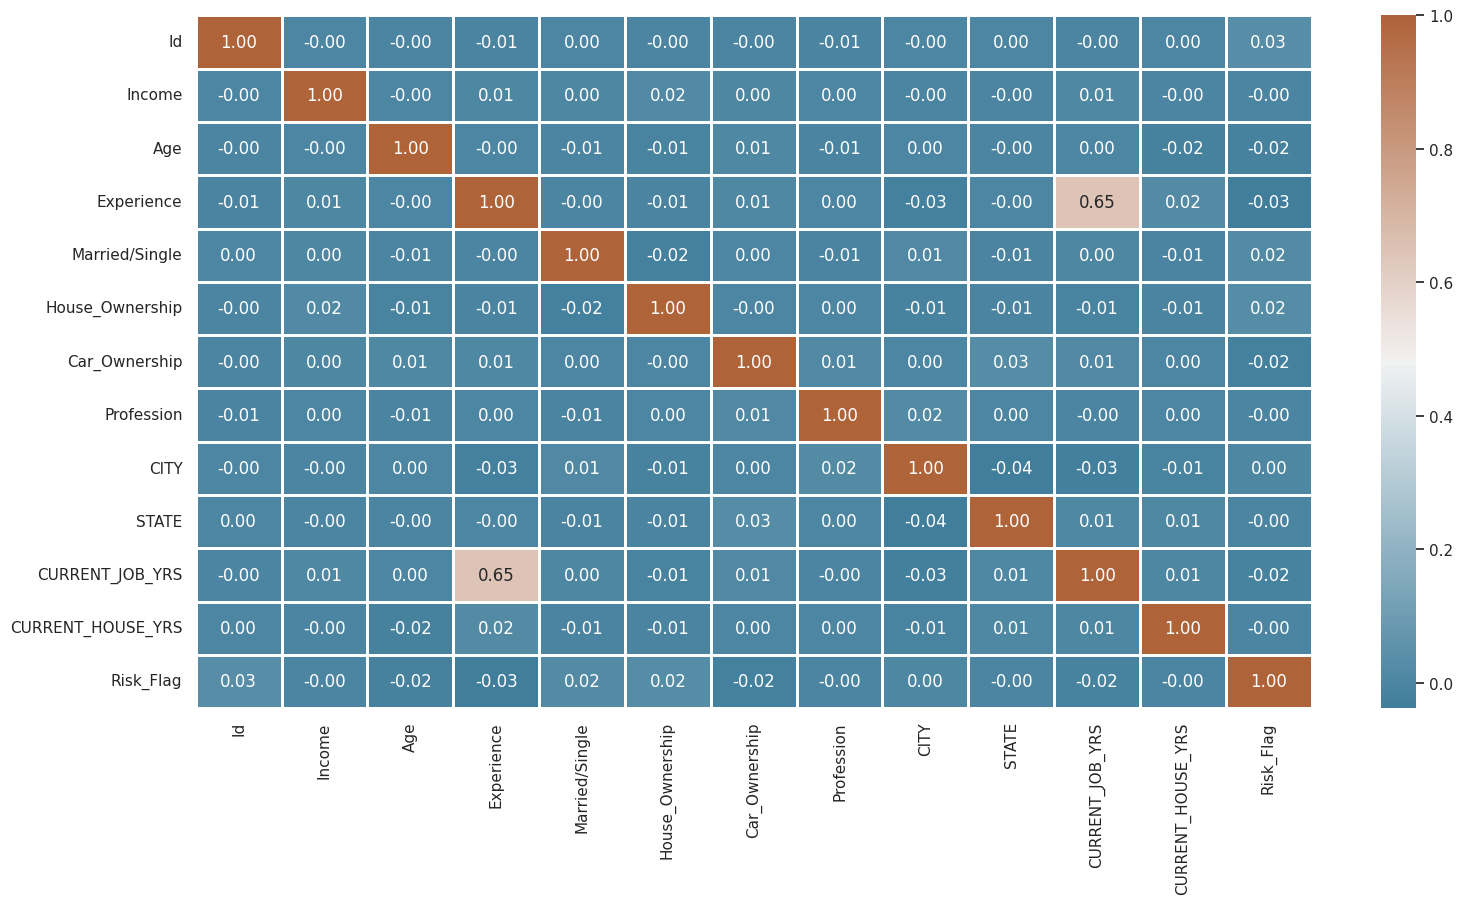

In [18]:
df_cor = df.copy()

for i in df_cor.columns:
    if df_cor[i].dtype == 'object':
        df_cor[i] = LabelEncoder().fit_transform(df[i])

plt.figure(figsize=(18, 9), facecolor='none')

cmap = sns.diverging_palette(230, 30, as_cmap=True)

size = {"size": 12}

sns.heatmap(
    df_cor.corr(),
    annot=True,
    cmap=cmap,
    square=False,
    linewidths=.9,
    fmt='.2f',
    annot_kws=size,
)
plt.show()

> Nhận xét

- Thu nhập và Tuổi: Có một mức độ tương quan nhỏ giữa Income và Age, cho thấy thu nhập có xu hướng tăng nhẹ theo tuổi.

- Kinh nghiệm và Số năm công việc hiện tại: Có một mối tương quan mạnh giữa Experience và CURRENT_JOB_YRS, điều này là dễ hiểu vì cả hai chỉ số đều liên quan đến thời gian làm việc.

- Rủi ro và các biến khác: Có một mối tương quan nhỏ giữa Risk_Flag và các biến như Married/Single, Car_Ownership, và House_Ownership, cho thấy những yếu tố này có thể ảnh hưởng đến xác suất rủi ro.

- Sở hữu xe và Hôn nhân: Có một mức tương quan nhỏ giữa Car_Ownership và Married/Single, có thể cho thấy những người đã kết hôn có khả năng sở hữu xe hơi cao hơn.

### Checking for Outliers

<Axes: ylabel='Age'>

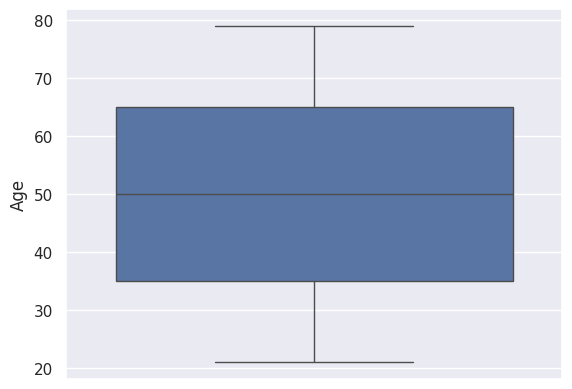

In [19]:
sns.boxplot(y = 'Age', data = df)

> Không có điểm dữ liệu nào được biểu diễn như ngoại lệ trên biểu đồ, điều này cho thấy không có giá trị tuổi nào quá cao hoặc quá thấp so với phần còn lại của nhóm dữ liệu.

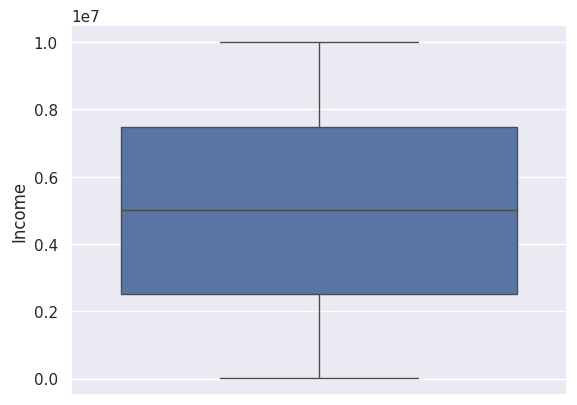

In [20]:
sns.boxplot(y = 'Income', data = df);

> Không có điểm ngoại lai nào được hiển thị, dữ liệu có thể rất đồng đều và không có giá trị nào quá cao hoặc quá thấp so với phần còn lại của tập dữ liệu

<ipython-input-21-92f3f890dd55>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Risk_Flag', data=df, palette="Set3")


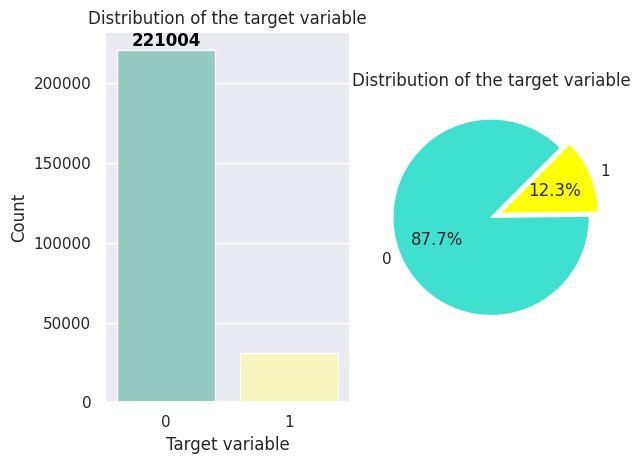

In [21]:
plt.subplot(1,2,1)
ax = sns.countplot(x='Risk_Flag', data=df, palette="Set3")
plt.title('Distribution of the target variable')
plt.xlabel('Target variable')
plt.ylabel('Count')
ax.bar_label(ax.containers[0], fontsize=12, color='black', fontweight='bold')
plt.subplot(1,2,2)
plt.pie(df.Risk_Flag.value_counts(), labels = df.Risk_Flag.value_counts().index, autopct = '%1.1f%%', startangle = 45, explode = (0, 0.1), colors = ['turquoise', 'yellow'] )
plt.title('Distribution of the target variable')
plt.tight_layout()
plt.show()

In [22]:
print(len(df.Profession.unique()))
print(len(df.STATE.unique()))
print(len(df.CITY.unique()))

51
29
317


### Tóm tắt về trực quan hóa dữ liệu
- Lớp 0 chiếm 88% tập dữ liệu, trong khi lớp 1 chỉ chiếm 12%. Các lớp bị sai lệch rất nhiều, chúng ta cần giải quyết vấn đề này
- Không có ngoại lệ trong tập dữ liệu. Nhưng chúng ta cần chuẩn hóa Age và Income
- Mối tương quan chặt chẽ giữa Experience và CURRENT_JOB_YRS. Có thể bỏ một cột trong quá trình lựa chọn tính năng hoặc sử dụng Phân tích thành phần chính (PCA)
- Married/Single House_Ownership Car_Ownership có thể được mã hóa nhị phân hoặc dùng mã hóa one-hot
- Có thể tìm mối liên hệ giữa biến mục tiêu và biến phân loại bằng phép kiểm Chi bình phương

### Feature Engineering

Helping function for hypothesis testing

In [23]:
def chi_square_test(data):
    stat, p, dof, expected = chi2_contingency(data)
    alpha = 0.05
    print("p value is " + str(p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (H0 holds true)')

### Chi Square Test

In [24]:
car_ownership_risk_flag = pd.crosstab(df["Car_Ownership"], df["Risk_Flag"])
car_ownership_risk_flag

Risk_Flag,0,1
Car_Ownership,,
no,153439,22561
yes,67565,8435


In [25]:
chi_square_test(car_ownership_risk_flag)

p value is 1.7350853850183746e-33
Dependent (reject H0)


In [26]:
marital_status_risk_flag = pd.crosstab(df["Married/Single"], df["Risk_Flag"])
marital_status_risk_flag

Risk_Flag,0,1
Married/Single,,
married,23092,2636
single,197912,28360


In [27]:
chi_square_test(marital_status_risk_flag)

p value is 3.773053705715196e-26
Dependent (reject H0)


In [28]:
house_ownership_risk_flag = pd.crosstab(df["House_Ownership"], df["Risk_Flag"])
house_ownership_risk_flag

Risk_Flag,0,1
House_Ownership,,
norent_noown,6469,715
owned,11758,1160
rented,202777,29121


In [29]:
chi_square_test(house_ownership_risk_flag)

p value is 1.8381930028370595e-40
Dependent (reject H0)


### Performing Principal Component Analysis on CURRENT_JOB_YRS and Experience

In [30]:
features = ["CURRENT_JOB_YRS","Experience"]

df_for_pca = df[features]
scaled_df_for_pca = (df_for_pca - df_for_pca.mean(axis=0))/df_for_pca.std()
scaled_df_for_pca

,CURRENT_JOB_YRS,Experience
0,-0.914129,-1.180230
1,0.731035,-0.014067
2,-0.639935,-1.013635
3,-1.188323,-1.346825
4,-0.914129,0.152528
...,...,...
251995,-0.091547,0.485718
251996,-0.091547,-0.014067
251997,0.182647,-0.513851
251998,-1.736711,-1.680014


In [31]:
pca = PCA()
df_pca = pca.fit_transform(scaled_df_for_pca)
component_names = [f"PC{i+1}" for i in range(df_pca.shape[1])]
df_pca = pd.DataFrame(df_pca, columns=component_names)

df_pca.head()

,PC1,PC2
0,-1.480935,-0.188162
1,0.506973,-0.526866
2,-1.169251,-0.264246
3,-1.792620,-0.112078
4,-0.538533,0.754240


In [32]:
df1 = pd.concat([df,df_pca],axis=1)
df1.head()

,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,PC1,PC2
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0,-1.480935,-0.188162
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0,0.506973,-0.526866
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0,-1.169251,-0.264246
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1,-1.792620,-0.112078
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1,-0.538533,0.754240


### Prepare data for training

Label encoding for categorical variables

In [33]:
features = ['Married/Single','Car_Ownership','Profession','CITY','STATE']
label_encoder = LabelEncoder()

for col in features:
    df1[col] = label_encoder.fit_transform(df1[col])

In [34]:
df2 = pd.get_dummies(df1, columns = ["House_Ownership"])
df2.drop(["Id"],axis=1,inplace=True)
df2

,Income,Age,Experience,Married/Single,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag,PC1,PC2,House_Ownership_norent_noown,House_Ownership_owned,House_Ownership_rented
0,1303834,23,3,1,0,33,251,13,3,13,0,-1.480935,-0.188162,False,False,True
1,7574516,40,10,1,0,43,227,14,9,13,0,0.506973,-0.526866,False,False,True
2,3991815,66,4,0,0,47,8,12,4,10,0,-1.169251,-0.264246,False,False,True
3,6256451,41,2,1,1,43,54,17,2,12,1,-1.792620,-0.112078,False,False,True
4,5768871,47,11,1,0,11,296,22,3,14,1,-0.538533,0.754240,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251995,8154883,43,13,1,0,45,162,28,6,11,0,0.278721,0.408188,False,False,True
251996,2843572,26,10,1,0,3,251,13,6,11,0,-0.074680,0.054787,False,False,True
251997,4522448,46,7,1,0,17,144,14,7,12,0,-0.234197,-0.492498,False,False,True
251998,6507128,45,0,1,0,27,233,18,0,10,0,-2.415990,0.040091,False,False,True


#### Split data

In [35]:
X = df2.drop(['Risk_Flag'],axis=1)
y = df2.Risk_Flag
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [36]:
sm = SMOTE(random_state = 1000)
X_res, y_res = sm.fit_resample(X_train, y_train)

Now the data is ready for implementation of Machine Learning model!!<br>
Since the target variable is either 0 or 1, So we will use ml models which is suitable for binary classification

### Machine learning model for Binary classification

### Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE


# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_res)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter = 500000, C = 0.01, penalty = 'l2', solver = 'sag')
model.fit(X_train_scaled, y_res)
y_pred = model.predict(X_test_scaled)
accuracy_logis = model.score(X_test_scaled, y_test)
accuracy_logis

0.6132275132275132

In [49]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.64      0.74     66338
           1       0.14      0.44      0.22      9262

    accuracy                           0.61     75600
   macro avg       0.52      0.54      0.48     75600
weighted avg       0.80      0.61      0.68     75600



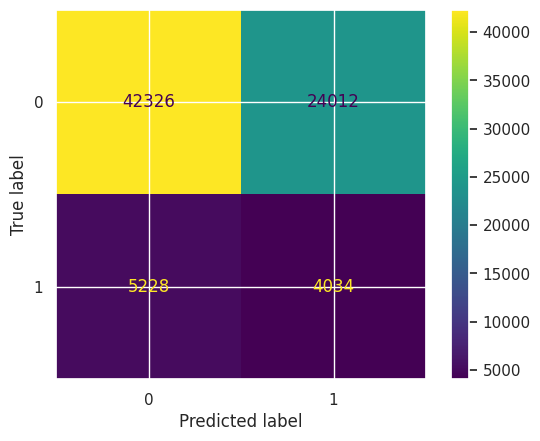

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

con_max = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

> Nhận xét:

- Precision thấp cho lớp 1 (Default):

  - Precision cho lớp 1 (vỡ nợ) là 0.14, rất thấp, có nghĩa là trong số những dự đoán là vỡ nợ, chỉ có 14% là đúng. Điều này cho thấy mô hình thường dự đoán sai là người sẽ vỡ nợ.

- Recall thấp cho lớp 0 (No Default):

  - Recall cho lớp 0 (không vỡ nợ) là 0.64, có nghĩa là trong số những người thực sự không vỡ nợ, mô hình chỉ dự đoán đúng 64%. Điều này cho thấy mô hình thường bỏ sót nhiều người không vỡ nợ.

- F1-score thấp cho lớp 1:

  - F1-score cho lớp 1 (vỡ nợ) là 0.22, rất thấp, cho thấy mô hình không cân bằng tốt giữa Precision và Recall cho lớp này.

- Ma trận nhầm lẫn:

  - Số lượng FP (24012) và FN (5228) khá cao, đặc biệt là số FP cao, cho thấy mô hình thường xuyên dự đoán nhầm người không vỡ nợ thành vỡ nợ.

Kết luận:
- Mô hình Logistic Regression hiện tại có hiệu suất chưa tốt, đặc biệt là trong việc dự đoán lớp vỡ nợ (class 1).
- Precision và Recall cho lớp vỡ nợ đều thấp, điều này có thể do sự mất cân bằng lớp trong dữ liệu (có nhiều người không vỡ nợ hơn người vỡ nợ).

Để cải thiện mô hình nên:
- Cân bằng lại dữ liệu: Sử dụng các kỹ thuật như SMOTE hoặc undersampling để cân bằng số lượng mẫu giữa các lớp.
- Tinh chỉnh hyperparameters: Điều chỉnh các tham số của mô hình Logistic Regression.

### KNN

In [51]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
param_grid = {
    'n_neighbors': [3, 5, 7, 9],
    'p': [1, 2],
    'metric': ['minkowski', 'euclidean']
}

knn = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, verbose=3, scoring='accuracy')
grid_search.fit(X_res, y_res)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_params, best_score

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END metric=minkowski, n_neighbors=3, p=1;, score=0.611 total time=   5.4s
[CV 2/5] END metric=minkowski, n_neighbors=3, p=1;, score=0.805 total time=   7.2s
[CV 3/5] END metric=minkowski, n_neighbors=3, p=1;, score=0.789 total time=   6.5s
[CV 4/5] END metric=minkowski, n_neighbors=3, p=1;, score=0.796 total time=   5.2s
[CV 5/5] END metric=minkowski, n_neighbors=3, p=1;, score=0.789 total time=   6.6s
[CV 1/5] END metric=minkowski, n_neighbors=3, p=2;, score=0.606 total time=   5.1s
[CV 2/5] END metric=minkowski, n_neighbors=3, p=2;, score=0.800 total time=   5.8s
[CV 3/5] END metric=minkowski, n_neighbors=3, p=2;, score=0.784 total time=   6.9s
[CV 4/5] END metric=minkowski, n_neighbors=3, p=2;, score=0.791 total time=   6.0s
[CV 5/5] END metric=minkowski, n_neighbors=3, p=2;, score=0.784 total time=   6.7s
[CV 1/5] END metric=minkowski, n_neighbors=5, p=1;, score=0.608 total time=   5.2s
[CV 2/5] END metric=minkow

({'metric': 'minkowski', 'n_neighbors': 9, 'p': 1}, 0.7779184967564665)

In [52]:
knn_model = KNeighborsClassifier(n_neighbors=9,metric='minkowski',p=1)
knn_model.fit(X_res, y_res)
y_pred = knn_model.predict(X_test)
accuracy_knn = knn_model.score(X_test, y_test)
accuracy_knn

0.8659920634920635

In [53]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92     66338
           1       0.46      0.61      0.53      9262

    accuracy                           0.87     75600
   macro avg       0.70      0.75      0.72     75600
weighted avg       0.88      0.87      0.87     75600



> Nhận xét:

- Độ chính xác tổng thể cao: Mô hình KNN đạt độ chính xác tổng thể 87%, cho thấy mô hình phân loại đúng phần lớn các trường hợp.

- Precision cho lớp 1 thấp: Precision của lớp 1 (các trường hợp có rủi ro) là 0.46, nghĩa là chỉ 46% trong số các dự đoán dương tính là đúng. Điều này cho thấy mô hình có nhiều dự đoán dương tính sai.

- Recall cho lớp 1 tốt hơn: Recall của lớp 1 là 0.61, nghĩa là mô hình tìm được 61% các trường hợp có rủi ro thực sự. Điều này tốt hơn so với mô hình AdaBoost trước đó.

- F1-Score của lớp 1: F1-Score của lớp 1 là 0.53, cho thấy mô hình KNN có sự cân bằng giữa Precision và Recall tốt hơn so với AdaBoost.

- Macro và Weighted Averages: Các chỉ số trung bình (macro và weighted) cho thấy hiệu suất tổng thể của mô hình là ổn định và đáng tin cậy, đặc biệt với weighted avg do sự mất cân bằng giữa hai lớp.

### Random Forest Classification

In [54]:
from sklearn.ensemble import RandomForestClassifier

#### Use feature importance with random forest

In [55]:
gr_rf_model = RandomForestClassifier(class_weight="balanced", random_state=101, max_depth=12, n_estimators= 200, min_samples_split = 3)
gr_rf_model.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12,
                       min_samples_split=3, n_estimators=200, random_state=101)

In [56]:
rf_feature_imp = pd.DataFrame(index = X.columns, data = gr_rf_model.feature_importances_,
                              columns = ["Feature Importance"]).sort_values("Feature Importance", ascending = False)
rf_feature_imp

,Feature Importance
Income,0.156703
CITY,0.139608
Age,0.131028
Profession,0.121232
STATE,0.093531
PC2,0.076709
PC1,0.070287
CURRENT_HOUSE_YRS,0.054881
Experience,0.052617
CURRENT_JOB_YRS,0.046180


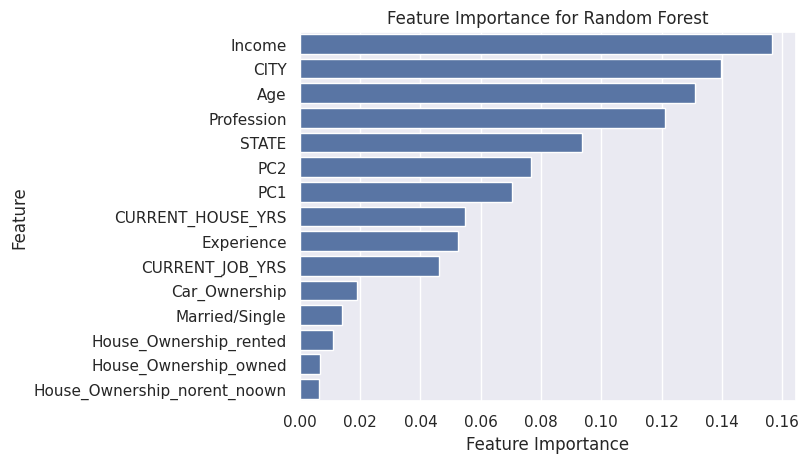

In [57]:
ax = sns.barplot(x=rf_feature_imp["Feature Importance"], y=rf_feature_imp.index)
plt.ylabel("Feature")
plt.title("Feature Importance for Random Forest")
plt.show()

In [58]:
new_df = df2[["Income", "CITY", "Age", "Profession", "STATE", "PC2", "PC1", "CURRENT_HOUSE_YRS", "Risk_Flag"]]
X_new = new_df.drop('Risk_Flag',axis=1)
y_new = new_df['Risk_Flag']
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.2, stratify=y, random_state = 101)

In [59]:
rf_model = RandomForestClassifier(class_weight="balanced", random_state=101)
rf_model.fit(X_train_new,y_train_new)
y_pred_new = rf_model.predict(X_test_new)
accuracy_rf = rf_model.score(X_test_new, y_test_new)
accuracy_rf

0.8958531746031746

In [60]:
print(classification_report(y_test_new,y_pred_new))

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     44201
           1       0.56      0.77      0.64      6199

    accuracy                           0.90     50400
   macro avg       0.76      0.84      0.79     50400
weighted avg       0.91      0.90      0.90     50400



[Text(0.5, 32.249999999999986, 'Predicted Class'),
 Text(91.25, 0.5, 'Actual Class')]

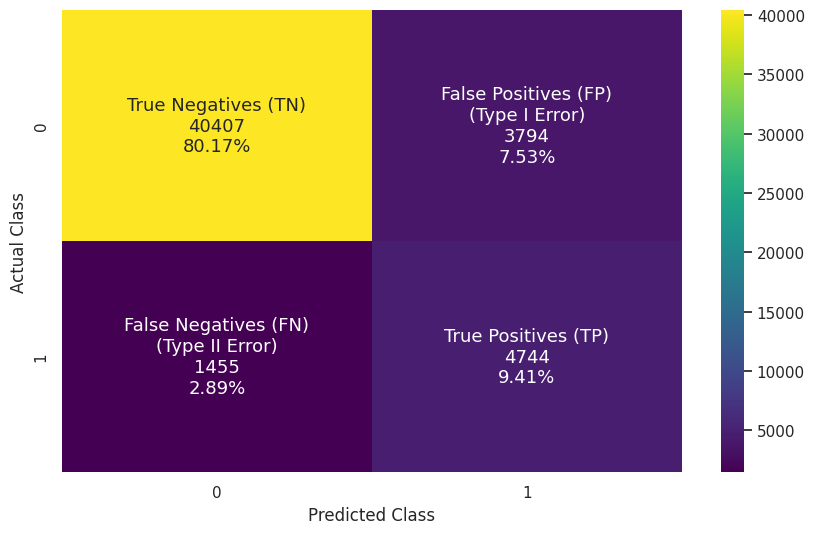

In [61]:
plt.figure(figsize=(10,6))

y_pred_new = rf_model.predict(X_test_new)
cf_matrix = confusion_matrix(y_test_new, y_pred_new)

group_names = ['True Negatives (TN)', 'False Positives (FP)\n(Type I Error)',
               'False Negatives (FN)\n(Type II Error)', 'True Positives (TP)']
group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]

labels = np.asarray(labels).reshape(2, 2)

ax = sns.heatmap(cf_matrix, annot=labels, fmt="", annot_kws={'size': 13}, cmap='viridis')
ax.set(xlabel='Predicted Class', ylabel = 'Actual Class')

> Nhận xét

- True Negatives (TN):

    - Số lượng: 40407
    - Tỷ lệ: 80.17%
    - Đây là số lượng mẫu thuộc lớp 0 (âm tính) mà mô hình dự đoán chính xác là âm tính. Con số này khá lớn, cho thấy mô hình có khả năng phát hiện các trường hợp âm tính khá tốt.

- False Positives (FP) (Type I Error):

    - Số lượng: 3794
    - Tỷ lệ: 7.53%
    - Đây là số lượng mẫu thuộc lớp 0 nhưng mô hình lại dự đoán là lớp 1 (dương tính). Tỷ lệ này không quá cao, nhưng vẫn cần được cải thiện để giảm thiểu các dự đoán sai lệch.

- False Negatives (FN) (Type II Error):

    - Số lượng: 1455
    - Tỷ lệ: 2.89%
    - Đây là số lượng mẫu thuộc lớp 1 (dương tính) nhưng mô hình lại dự đoán là lớp 0. Tỷ lệ này khá thấp, cho thấy mô hình có khả năng phát hiện các trường hợp dương tính tốt, nhưng vẫn còn một số trường hợp bị bỏ sót.

- True Positives (TP):

    - Số lượng: 4744
    - Tỷ lệ: 9.41%
    - Đây là số lượng mẫu thuộc lớp 1 mà mô hình dự đoán chính xác là dương tính. Tỷ lệ này thể hiện khả năng của mô hình trong việc nhận diện các trường hợp dương tính.

Tổng quan:

- Mô hình Random Forest này có độ chính xác tương đối cao trong việc nhận diện các trường hợp âm tính (TN) và dương tính (TP).
- Số lượng FP và FN không quá cao, nhưng vẫn cần được chú ý để cải thiện hơn nữa.
- Để cải thiện mô hình, nên xem xét việc cân bằng lại dữ liệu (data balancing).

### AdaBoost Classifier

In [62]:
from sklearn.ensemble import AdaBoostClassifier

In [65]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1]
}

grid_search = GridSearchCV(estimator=AdaBoostClassifier(random_state=15000), param_grid=param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
grid_search.fit(X_res, y_res)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Score: {best_score}")

best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

accuracy_ada = accuracy_score(y_test, y_pred_best)
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)
roc_auc_best = roc_auc_score(y_test, y_pred_best)

print(f"Test Set Accuracy: {accuracy_ada}")
print(f"Test Set Precision: {precision_best}")
print(f"Test Set Recall: {recall_best}")
print(f"Test Set F1-score: {f1_best}")
print(f"Test Set ROC-AUC: {roc_auc_best}")

print("Confusion Matrix for Best Model:")
print(confusion_matrix(y_test, y_pred_best))
print("\nClassification Report for Best Model:")
print(classification_report(y_test, y_pred_best))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'learning_rate': 1, 'n_estimators': 150}
Best Cross-Validation Score: 0.6007558992415213
Test Set Accuracy: 0.5802910052910053
Test Set Precision: 0.14856409935556528
Test Set Recall: 0.5127402288922479
Test Set F1-score: 0.23037741340836326
Test Set ROC-AUC: 0.5512312799922664
Confusion Matrix for Best Model:
[[39121 27217]
 [ 4513  4749]]

Classification Report for Best Model:
              precision    recall  f1-score   support

           0       0.90      0.59      0.71     66338
           1       0.15      0.51      0.23      9262

    accuracy                           0.58     75600
   macro avg       0.52      0.55      0.47     75600
weighted avg       0.80      0.58      0.65     75600



> Nhận xét:

- Độ chính xác (Accuracy): Mô hình đạt độ chính xác tổng thể là 58%, thấp hơn so với kỳ vọng cho một mô hình dự đoán rủi ro.

- Precision và Recall (lớp 1): Precision cho lớp 1 (các trường hợp có rủi ro) là 0.1486, nghĩa là mô hình chỉ đúng 14.86% khi dự đoán là có rủi ro. Recall là 0.5127, nghĩa là mô hình tìm được 51.27% các trường hợp có rủi ro thực sự.

- F1-Score (lớp 1): F1-Score cho lớp 1 là 0.2304, cho thấy sự cân bằng giữa Precision và Recall không tốt.

- ROC-AUC: Điểm ROC-AUC là 0.5512, cho thấy mô hình chỉ hơi tốt hơn một chút so với dự đoán ngẫu nhiên.

### Gradient Boosting

In [66]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5]
}

model = GradientBoostingClassifier()

grid_search = GridSearchCV(model, param_grid, cv=3, verbose=2)

grid_search.fit(X_res, y_res)

best_params = grid_search.best_params_

best_model = GradientBoostingClassifier(**best_params)

best_model.fit(X_res, y_res)

accuracy_gra = best_model.score(X_test, y_test)
accuracy_gra

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=  17.0s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=  16.2s
[CV] END ...learning_rate=0.01, max_depth=3, n_estimators=50; total time=  16.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  34.6s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  34.1s
[CV] END ..learning_rate=0.01, max_depth=3, n_estimators=100; total time=  32.8s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=  26.9s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=  27.1s
[CV] END ...learning_rate=0.01, max_depth=5, n_estimators=50; total time=  26.8s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=  53.2s
[CV] END ..learning_rate=0.01, max_depth=5, n_estimators=100; total time=  52.9s
[CV] END ..learning_rate=0.01, max_depth=5, n_est

0.7020899470899471

In [67]:
y_pred = best_model.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.71      0.81     66338
           1       0.24      0.67      0.36      9262

    accuracy                           0.70     75600
   macro avg       0.59      0.69      0.58     75600
weighted avg       0.85      0.70      0.75     75600



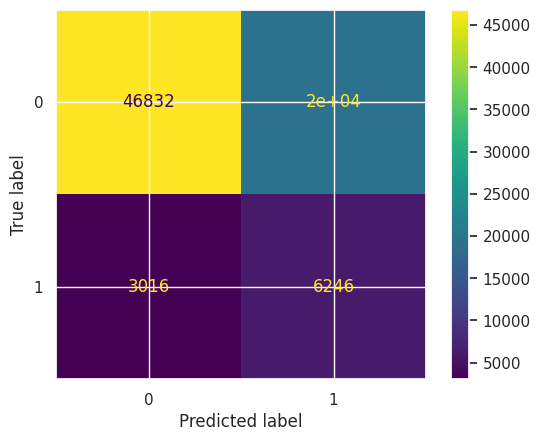

In [68]:
con_max = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

-	Lớp 0 (Không vỡ nợ):
  + Precision cao (0.94): Khi mô hình dự đoán một khách hàng không vỡ nợ, nó chính xác đến 94%.
  + Recall thấp hơn (0.71): Chỉ có 71% của tổng số khách hàng thực sự không vỡ nợ được mô hình dự đoán chính xác.
  + F1-score (0.81): Điểm số này cho thấy một sự cân bằng giữa precision và recall, nhưng vẫn có không gian để cải thiện, đặc biệt là về mặt recall.
-	Lớp 1 (Vỡ nợ):
  + Precision thấp (0.24): Chỉ có 24% trong số những dự đoán vỡ nợ của mô hình là chính xác.
  + Recall cao hơn (0.67): Mô hình có khả năng nhận diện 67% của những trường hợp thực sự vỡ nợ.
  + F1-score thấp (0.36): Điểm số này cho thấy mô hình không hiệu quả lắm trong việc dự đoán lớp vỡ nợ, chủ yếu do precision thấp.
- Accuracy tổng thể (0.70): Mô hình chính xác 70% trên toàn bộ dữ liệu kiểm tra.

- Nhận xét chung:
  + Mô hình có vẻ tốt trong việc nhận diện khách hàng không vỡ nợ nhưng không hiệu quả trong việc nhận diện khách hàng vỡ nợ.
  + Precision thấp cho lớp 1 có thể dẫn đến việc từ chối tín dụng cho nhiều khách hàng tiềm năng không vỡ nợ.


### Naive Bayes

In [71]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('feature_selection', SelectKBest(f_classif)),
    ('classifier', GaussianNB(var_smoothing=1e-8))
])


# Huấn luyện mô hình với pipeline
pipeline.fit(X_res, y_res)

# Dự đoán trên tập kiểm tra và tính toán độ chính xác
y_pred = pipeline.predict(X_test)
accuracy_naive = pipeline.score(X_test, y_test)

print("Accuracy:", accuracy_naive)
print(classification_report(y_test,y_pred))


Accuracy: 0.36858465608465607
              precision    recall  f1-score   support

           0       0.90      0.31      0.47     66338
           1       0.13      0.75      0.23      9262

    accuracy                           0.37     75600
   macro avg       0.52      0.53      0.35     75600
weighted avg       0.81      0.37      0.44     75600



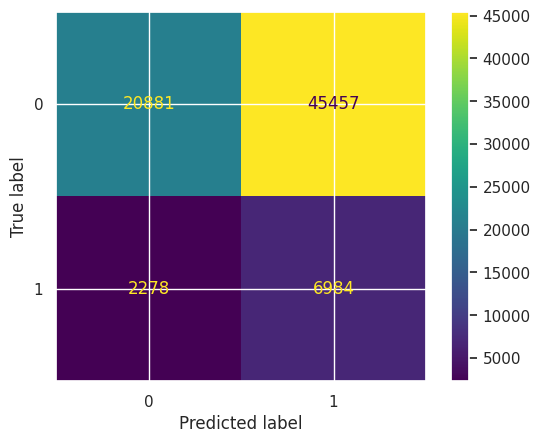

In [72]:
con_max = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()

- Lớp 0 (Không vỡ nợ):
  + Precision cao (0.90): Khi mô hình dự đoán một khách hàng không vỡ nợ chính xác đến 89%
  + Recall thấp (0.31): Có 31% của tổng số khách hàng thực sự không vỡ nợ được mô hình dự đoán chính xác.
  + F1-score cao hơn (0.47): Điểm số này cho thấy mô hình dự đoán chính xác 47% lớp không vỡ nợ, chủ yếu do recall thấp.
-	Lớp 1 (Vỡ nợ):
  + Precision thấp (0.13): Chỉ có 13% trong số những dự đoán vỡ nợ của mô hình là chính xác.
  + Recall cao hơn (0.75): Mô hình có khả năng nhận diện 75% của những trường hợp thực sự vỡ nợ.
  + F1-score thấp (0.23): Điểm số này cho thấy mô hình không hiệu quả lắm trong việc dự đoán lớp vỡ nợ, chủ yếu do precision rất thấp.
- Accuracy tổng thể (0.37): Mô hình chính xác 37% trên toàn bộ dữ liệu kiểm tra.

- Nhận xét chung:
  + Mô hình này có vẻ không cân bằng giữa hai lớp. Mặc dù có precision cao cho lớp không vỡ nợ, nhưng recall thấp cho thấy mô hình bỏ qua nhiều trường hợp thực sự không vỡ nợ.
  + Đối với lớp vỡ nợ, mô hình có recall cao nhưng precision rất thấp, điều này có nghĩa là mô hình dự đoán quá nhiều trường hợp là vỡ nợ khi chúng không phải, dẫn đến nhiều báo động giả.
  + Độ chính xác tổng thể thấp cho thấy mô hình này có thể không phù hợp để đưa ra quyết định về việc cấp tín dụng.


### Kết luận
Random Forest phù hợp nhất với tập dữ liệu với độ chính xác lên đến 90%


### Build model ANNs

#### Define data for ANNs model

In [37]:
# import for model
from sklearn.preprocessing import OneHotEncoder, StandardScaler, QuantileTransformer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks
import joblib
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

In [38]:
from sklearn.compose import ColumnTransformer
tr1 = ColumnTransformer([
    ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), [3, 4, 5, 6, 7, 8, 11]),
    ('std', StandardScaler(), [0]),
    ('qtl_trsf', QuantileTransformer(output_distribution="normal"), [1, 2, 9, 10])
])

X_train_Scaled = tr1.fit_transform(X_train)
X_test_Scaled = tr1.transform(X_test)

In [42]:
ann_model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(256, activation='elu', kernel_initializer='he_normal', input_shape=(X_train_Scaled.shape[1],)),
    tf.keras.layers.Dense(128, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.Dense(32, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(8, activation='elu', kernel_initializer='he_normal'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
ann_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 256)               147456    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_3 (Bat  (None, 128)               512       
 chNormalization)                                                
                                                                 
 dense_8 (Dense)             (None, 64)                8256      
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 batch_normalization_4 (Bat  (None, 32)                128       
 chNormalization)                                     

In [43]:
# Compile the model
ann_model.compile(optimizer='Nadam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [44]:
import time
n_epochs = 23
new_training = 1
time_chay = 0
if new_training:
    model_saver = keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Colab Notebooks/LoanPrediction_Model/ann_model.h5',monitor='val_accuracy', save_best_only=True)
    early_stopper = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    performance_sched = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2)
    #with tf.device('/gpu:0'):
    start_time = time.time()
    history = ann_model.fit(X_train_Scaled, y_train, epochs=n_epochs,
                              batch_size=32,
                              validation_data=(X_test_Scaled, y_test),
                              callbacks=[model_saver, early_stopper, performance_sched], verbose=1)
    end_time = time.time()
    time_chay = end_time - start_time
    print("Thời gian chạy: ", time_chay)
    history = history.history
    joblib.dump(history,'/content/drive/MyDrive/Colab Notebooks/LoanPrediction_Model/history_ann_model')
else:
    try:
        ann_model = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/LoanPrediction_Model/ann_model.h5')
        history = joblib.load('/content/drive/MyDrive/Colab Notebooks/LoanPrediction_Model/history_ann_model')
    except Exception as e:
        history = joblib.load('/content/drive/MyDrive/Colab Notebooks/LoanPrediction_Model/history_ann_model')

history.keys()
print("Train_Accuracy:", history['accuracy'][-1])
print("Val_Accuracy:", history['val_accuracy'][-1])
#endregion

Epoch 1/23
5513/5513 [==============================] - 59s 9ms/step - loss: 0.3433 - accuracy: 0.8738 - val_loss: 0.2841 - val_accuracy: 0.8864 - lr: 0.0010
Epoch 2/23
   7/5513 [..............................] - ETA: 48s - loss: 0.2215 - accuracy: 0.8973 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5513/5513 [==============================] - 49s 9ms/step - loss: 0.2749 - accuracy: 0.8864 - val_loss: 0.2581 - val_accuracy: 0.8920 - lr: 0.0010
Epoch 3/23
5513/5513 [==============================] - 55s 10ms/step - loss: 0.2491 - accuracy: 0.8921 - val_loss: 0.2468 - val_accuracy: 0.8921 - lr: 0.0010
Epoch 4/23
5513/5513 [==============================] - 49s 9ms/step - loss: 0.2341 - accuracy: 0.8939 - val_loss: 0.2396 - val_accuracy: 0.8946 - lr: 0.0010
Epoch 5/23
5513/5513 [==============================] - 55s 10ms/step - loss: 0.2237 - accuracy: 0.8955 - val_loss: 0.2395 - val_accuracy: 0.8935 - lr: 0.0010
Epoch 6/23
5513/5513 [==============================] - 50s 9ms/step - loss: 0.2147 - accuracy: 0.8966 - val_loss: 0.2358 - val_accuracy: 0.8940 - lr: 0.0010
Epoch 7/23
5513/5513 [==============================] - 50s 9ms/step - loss: 0.2063 - accuracy: 0.8978 - val_loss: 0.2336 - val_accuracy: 0.8936 - lr: 0.0010
Epoch 8/23
5513/5513 [==============================] - 50s 9

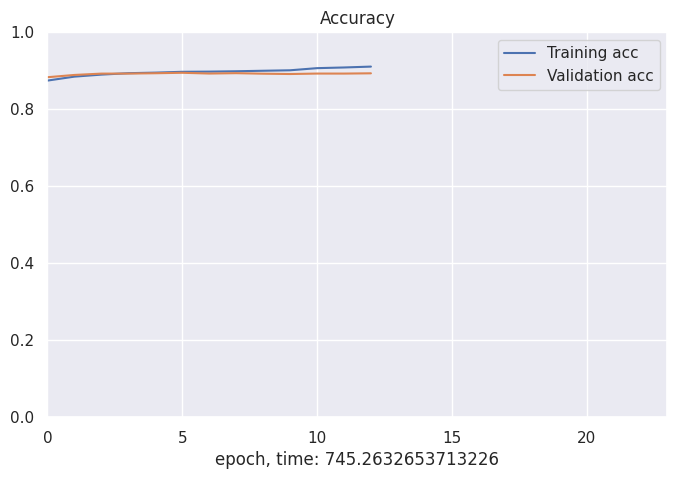

In [ ]:
# %% Plot learning curves
import pandas as pd
pd.DataFrame({'Training acc':history['accuracy'],'Validation acc':history['val_accuracy']}).plot(figsize=(8, 5))
plt.grid(True)
plt.xlim(0, n_epochs)
plt.ylim(0, 1)
plt.xlabel(f'epoch, time: {time_chay}') # train lại làm mất time chạy
plt.xticks(np.arange(0,n_epochs+1,5))
plt.savefig("/content/drive/MyDrive/Colab Notebooks/LoanPrediction_Model/ann_model") # Dùng hình ảnh để lưu, và thay đổi tên hình lưu cho từng thuật toán
plt.title("Accuracy")
plt.show()


> Nhận xét

Hiệu suất Mô hình:
- Training Accuracy: 0.91
- Validation Accuracy: 0.89

Quá trình Huấn luyện:
- Loss và Accuracy cải thiện qua các epoch:
  - Ban đầu, loss giảm và accuracy tăng đáng kể.
  - Từ epoch thứ 7 trở đi, các chỉ số không cải thiện đáng kể và có dấu hiệu dao động nhẹ, cho thấy mô hình có thể đã đạt tới mức bão hòa.

Đánh giá:
- Training và Validation Accuracy đều cao: Điều này cho thấy mô hình có khả năng học tốt từ dữ liệu huấn luyện và tổng quát tốt trên dữ liệu kiểm tra.
- Không có dấu hiệu Overfitting rõ ràng: Accuracy trên tập huấn luyện và kiểm tra không chênh lệch quá lớn, cho thấy mô hình không bị overfit.

In [73]:
y_pred = (ann_model.predict(X_test_Scaled) > 0.5).astype("int32")
accuracy_ann = accuracy_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

2363/2363 [==============================] - 4s 2ms/step
[[61306  5032]
 [ 3128  6134]]
              precision    recall  f1-score   support

           0       0.95      0.92      0.94     66338
           1       0.55      0.66      0.60      9262

    accuracy                           0.89     75600
   macro avg       0.75      0.79      0.77     75600
weighted avg       0.90      0.89      0.90     75600



> Nhận xét chi tiết:

- Độ chính xác (Accuracy):

  - Độ chính xác khi kiểm thử dữ liệu thực tế của mô hình là 89%

- Precision cao cho lớp 0 (Không vỡ nợ):

  - Precision cho lớp 0 (0.95) rất cao, cho thấy mô hình dự đoán chính xác nhiều người không vỡ nợ.
  - Precision cho lớp 1 (0.55) thấp hơn, có nghĩa là trong số những dự đoán là vỡ nợ, chỉ có 55% là đúng.

- Recall cao cho cả hai lớp:

  - Recall cho lớp 0 (0.92) cao, cho thấy mô hình bắt được phần lớn người không vỡ nợ.
  - Recall cho lớp 1 (0.66) cũng tương đối cao, cho thấy mô hình bắt được phần lớn người vỡ nợ.

- F1-score:

  - F1-score cho lớp 0 (0.94) cao, cho thấy sự cân bằng tốt giữa precision và recall cho lớp này.
  - F1-score cho lớp 1 (0.60) cũng khá tốt, nhưng thấp hơn lớp 0.

Kết luận:
- Mô hình ANN đã được cải thiện đáng kể, đặc biệt là về độ chính xác tổng thể và khả năng nhận diện người vỡ nợ.
- Mặc dù precision cho lớp 1 vẫn còn thấp, recall và F1-score của lớp này đã được cải thiện đáng kể.
- Mô hình ANN có thể được coi là phù hợp hơn cho bài toán này, nhưng vẫn có thể cần cải thiện thêm để nâng cao precision cho lớp 1.

### Tổng kết toàn bộ mô hình

In [74]:
data = {
    'Model': ['Logistic Regression', 'KNN', 'Random Forest', 'AdaBoost', 'Gradient Boosting', 'Naive Bayes', 'ANN'],
    'Accuracy': [accuracy_logis, accuracy_knn, accuracy_rf, accuracy_ada, accuracy_gra, accuracy_naive, accuracy_ann]
}

df = pd.DataFrame(data)

df

,Model,Accuracy
0,Logistic Regression,0.613228
1,KNN,0.865992
2,Random Forest,0.895853
3,AdaBoost,0.580291
4,Gradient Boosting,0.702090
5,Naive Bayes,0.368585
6,ANN,0.892063


> Nhận xét:

- Logistic Regression:

  - Mô hình Logistic Regression có độ chính xác là 61.32%, cải thiện so với lần trước nhưng vẫn thấp hơn nhiều so với các mô hình khác như KNN, Random Forest, và ANN. Điều này cho thấy Logistic Regression vẫn không phải là lựa chọn tốt nhất cho bài toán này.

- K-Nearest Neighbors (KNN):

  - KNN đạt độ chính xác 86.60%, một trong những mô hình có hiệu suất tốt. KNN hoạt động tốt trong bài toán này do có thể tận dụng được tính tương đồng của các điểm dữ liệu gần nhau.

- Random Forest:

  - Random Forest đạt độ chính xác cao nhất (89.59%), chỉ thua kém một chút so với ANN. Đây là mô hình rất mạnh trong việc dự đoán, đặc biệt là với dữ liệu phức tạp.

- AdaBoost:

  - AdaBoost có độ chính xác là 58.03%, vẫn thấp hơn các mô hình khác. AdaBoost có thể không phù hợp với dữ liệu này, có thể do dữ liệu có nhiều nhiễu.

- Gradient Boosting:

  - Gradient Boosting đạt độ chính xác 70.21%, cao hơn AdaBoost và Logistic Regression nhưng vẫn thấp hơn KNN và Random Forest. Gradient Boosting có tiềm năng tốt nhưng có thể cần thêm tinh chỉnh.

- Naive Bayes:

  - Naive Bayes có độ chính xác thấp nhất (36.86%). Điều này có thể do giả định độc lập của các biến không phù hợp với dữ liệu thực tế trong bài toán này.

- Artificial Neural Network (ANN):

  - ANN có độ chính xác cao thứ hai (89.21%), gần bằng với Random Forest. ANN có khả năng học các mẫu phức tạp trong dữ liệu, cho thấy tiềm năng mạnh mẽ trong việc dự đoán tỷ lệ vỡ nợ.

Kết luận:
- Random Forest và ANN là hai mô hình có hiệu suất tốt nhất, phù hợp cho bài toán dự đoán tỷ lệ vỡ nợ của người dân.
- KNN cũng là một mô hình tiềm năng với độ chính xác cao.
- Các mô hình như Logistic Regression, AdaBoost, và Naive Bayes có độ chính xác thấp hơn và có thể không phù hợp cho bài toán này.
- Gradient Boosting cần thêm tinh chỉnh để đạt được hiệu suất tốt hơn.